# 評価方法

分類されていないデータを認識し、どれだけ正しくカテゴリごとに分類できるかを算出した「平均精度」の高さを競い合います。

今回、活用するデータはLSWMD_25519となります。
LSWMD_25519のFailureType項目が分類されていない状態のデータに対し、正しいFailureTypeカテゴリを分類するプログラムを作成し、その平均精度を算出します。
平均精度とは、カテゴリごとに正しく分類できる精度を平均した値です。カテゴリごとに算出した精度（Aが正しく分類された数/Aのデータ数）を足し、カテゴリ数で割ります。

公平な評価を実施するために、以下の制限を設けています。
1. 外部パッケージをインストールするためのセルとsolution関数の中身のみを編集すること
2. 校舎のiMac上で最後のセルの実行時間が15分未満であること　（%%timeitの出力結果を確認してください）

※気になる点がある場合、Discordで気軽にお問合せください。

In [83]:
import numpy as np # https://numpy.org/ja/
import pandas as pd # https://pandas.pydata.org/
from sklearn.model_selection import train_test_split

外部パッケージを使用する場合、以下の方法でインストールを実施してください。

In [84]:
# 必要な外部パッケージは、以下の内容を編集しインストールしてください
#!pip install numpy
#!pip install pandas
#!pip install scikit-learn
#!pip install tensorflow
#!pip install Pillow
#!pip install lightgbm

以下のsolution関数のみ編集してください。

In [ ]:
def normalize_map(map):
    from PIL import Image

    # リサイズ後のサイズを指定
    resize_shape = (28, 28)
    
    # マップの次元を取得
    len_y, len_x = map.shape

    # マップの中心y座標とx座標を取得
    y_add = len_y // 2 + len_y % 2
    x_add = len_x // 2 + len_x % 2

    # 0の値のインデックスを取得
    y_indices, x_indices = np.where(map == 0)
    # 他の位置に置換
    map[y_indices, x_indices] = map[(y_indices + y_add) % len_y, (x_indices + x_add) % len_x]
    # 0の値のインデックスを取得
    y_indices, x_indices = np.where(map == 0)
    # 0の値を置換
    map[y_indices, x_indices] = 1

    # リサイズし1を減算
    map = Image.fromarray(map - 1.0)
    # mapから1を減算してPILイメージを作成
    resized_map = map.resize(resize_shape, Image.LANCZOS)

    return np.asarray(resized_map)


def preprocess_map(df, normalize_map):
    # データの正規化
    train_maps = np.array([normalize_map(x) for x in df['waferMap']])

    # # 1. 画像を水平方向に反転
    # flipped_horizontally = np.flip(train_maps, axis=2)
    # train_maps = np.concatenate((train_maps, flipped_horizontally), axis=0)

    # # 2. 画像を垂直方向に反転
    # flipped_vertically = np.flip(train_maps, axis=1)
    # train_maps = np.concatenate((train_maps, flipped_vertically), axis=0)

    # 3. 画像を90度回転
    rotated_90 = np.rot90(train_maps, k=1, axes=(1, 2))
    train_maps = np.concatenate((train_maps, rotated_90), axis=0)

    # 4. 画像を180度回転
    rotated_180 = np.rot90(train_maps, k=2, axes=(1, 2))
    train_maps = np.concatenate((train_maps, rotated_180), axis=0)

    # 5. 画像を270度回転
    rotated_270 = np.rot90(train_maps, k=3, axes=(1, 2))
    train_maps = np.concatenate((train_maps, rotated_270), axis=0)

    # データの形状を変更
    train_maps = train_maps.reshape(train_maps.shape + (1,))

    return train_maps


def create_model(input_shape, num_classes):
    import tensorflow as tf

    model = tf.keras.models.Sequential([
        # 畳み込みブロック1
        tf.keras.layers.Conv2D(8, 3, activation='relu', padding='same', input_shape=(input_shape)),
        tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),

        # 畳み込みブロック2
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),

        # 畳み込みブロック3
        tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(pool_size=2, strides=2),

        # ブロック4
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0),
        tf.keras.layers.Dense(256, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0),
        tf.keras.layers.Dense(256, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0),

        # 出力層
        tf.keras.layers.Dense(num_classes),
    ])

    return model


def calculate_class_weights(train_labels):
    from sklearn.utils.class_weight import compute_class_weight
    # クラスの重みを計算
    class_weights = compute_class_weight(class_weight='balanced', 
                                         classes=np.unique(train_labels), 
                                         y=train_labels)
    # クラスの重みを辞書型に変換
    return dict(enumerate(class_weights))


def solution(x_test_df, train_df):
    import os
    import tensorflow as tf

    os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

    failure_types = list(train_df['failureType'].unique())

    test_maps = preprocess_map(x_test_df, normalize_map)
    train_maps = preprocess_map(train_df, normalize_map)
    train_labels = np.array([failure_types.index(x) for x in train_df['failureType']] * 8)

    class_weights = calculate_class_weights(train_labels)

    # モデルの作成
    model = create_model(train_maps[0].shape, len(failure_types))
    model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    # EarlyStoppingコールバックの設定
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    model.fit(train_maps, train_labels, epochs=7, class_weight=class_weights, callbacks=[early_stopping], validation_split=0.2)

    # 各予測結果の平均を計算
    test_logits = np.mean(model.predict(test_maps).reshape(-1, len(x_test_df['waferMap']), len(failure_types)), axis=0)
    
    predictions = tf.nn.softmax(test_logits).numpy()

    answer = [failure_types[x.argmax()] for x in predictions]
    return pd.DataFrame({'failureType': answer}, index=x_test_df.index)

FileNotFoundError: [Errno 2] No such file or directory: '../work/input/LSWMD_25519.pkl'

solution関数は以下のように活用され、平均精度を計算します。

Epoch 1/7
4594/4594 [==============================] - 38s 8ms/step - loss: 0.4367 - accuracy: 0.8551 - val_loss: 0.2784 - val_accuracy: 0.8938
Epoch 2/7
4594/4594 [==============================] - 38s 8ms/step - loss: 0.2596 - accuracy: 0.9116 - val_loss: 0.1882 - val_accuracy: 0.9312
Epoch 3/7
4594/4594 [==============================] - 37s 8ms/step - loss: 0.2225 - accuracy: 0.9234 - val_loss: 0.1949 - val_accuracy: 0.9269
Epoch 4/7
4594/4594 [==============================] - 37s 8ms/step - loss: 0.1828 - accuracy: 0.9345 - val_loss: 0.1839 - val_accuracy: 0.9274
Epoch 5/7
4594/4594 [==============================] - 38s 8ms/step - loss: 0.1600 - accuracy: 0.9422 - val_loss: 0.1718 - val_accuracy: 0.9355
Epoch 6/7
4594/4594 [==============================] - 40s 9ms/step - loss: 0.1428 - accuracy: 0.9482 - val_loss: 0.1233 - val_accuracy: 0.9521
Epoch 7/7
638/638 [==============================] - 1s 2ms/step


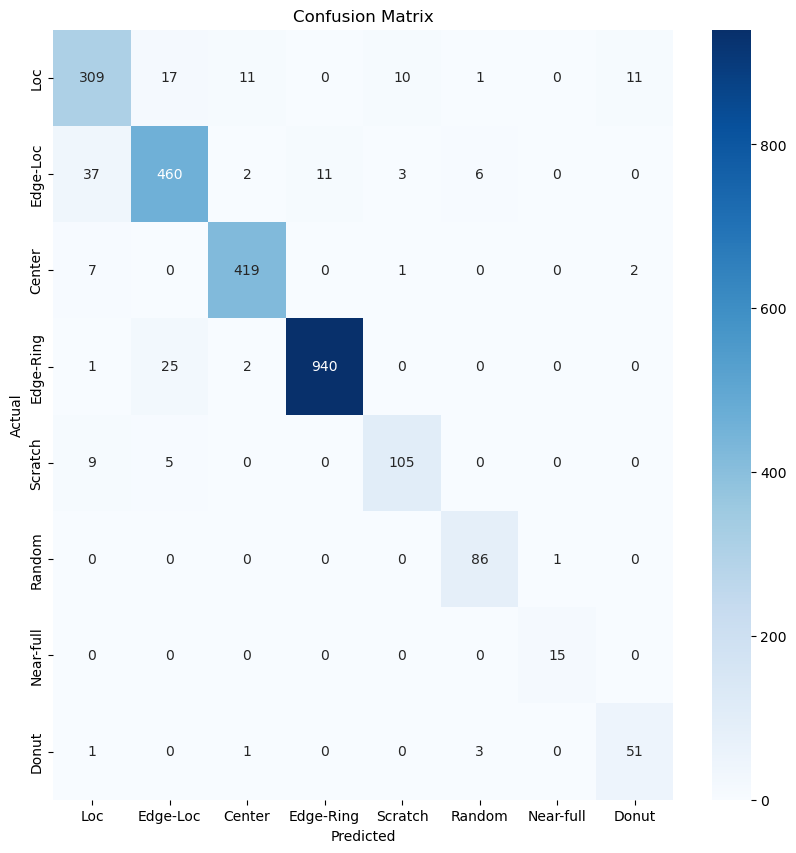


Class Accuracy and Most Common Errors:
Loc: Accuracy: 86.07%
    Most common error: Mistaken for Edge-Loc (4.74%)
Edge-Loc: Accuracy: 88.63%
    Most common error: Mistaken for Loc (7.13%)
Center: Accuracy: 97.67%
    Most common error: Mistaken for Loc (1.63%)
Edge-Ring: Accuracy: 97.11%
    Most common error: Mistaken for Edge-Loc (2.58%)
Scratch: Accuracy: 88.24%
    Most common error: Mistaken for Loc (7.56%)
Random: Accuracy: 98.85%
    Most common error: Mistaken for Near-full (1.15%)
Near-full: Accuracy: 100.00%
Donut: Accuracy: 91.07%
    Most common error: Mistaken for Random (5.36%)
平均精度：93.45%
4min 31s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [76]:
%%timeit -r 1 -n 1

def plot_confusion_matrix_and_accuracy(y_true, y_pred, classes):
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix

    # Confusion matrixの計算
    cm = confusion_matrix(y_true, y_pred, labels=classes)

    # ヒートマップとしてプロット
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # 各クラスごとの正確さと最も間違えやすいクラスを表示
    print("\nClass Accuracy and Most Common Errors:")
    for i, class_name in enumerate(classes):
        accuracy = cm[i, i] / cm[i, :].sum()
        print(f"{class_name}: Accuracy: {accuracy * 100:.2f}%")
        
        # 最も間違えやすいクラスを特定
        error_indices = cm[i, :].argsort()[-2:-1] if accuracy < 1 else []
        for error_index in error_indices:
            error_rate = cm[i, error_index] / cm[i, :].sum()
            error_class = classes[error_index]
            print(f"    Most common error: Mistaken for {error_class} ({error_rate * 100:.2f}%)")

# データのインポート
df=pd.read_pickle("../input/LSWMD_25519.pkl")

# テスト用と学習用のデータを作成（テストする際は、random_stateの値などを編集してみてください）
train_df, test_df = train_test_split(df, stratify=df['failureType'], test_size=0.10, random_state=42)

y_test_df = test_df[['failureType']]
x_test_df = test_df.drop(columns=['failureType'])

# solution関数を実行
user_result_df = solution(x_test_df, train_df)
plot_confusion_matrix_and_accuracy(y_test_df['failureType'], user_result_df['failureType'], df['failureType'].unique())

average_accuracy = 0
# ユーザーの提出物のフォーマット確認
if type(y_test_df) == type(user_result_df) and y_test_df.shape == user_result_df.shape:
    # 平均精度の計算
    accuracies = {}
    for failure_type in df['failureType'].unique():
        y_test_df_by_failure_type = y_test_df[y_test_df['failureType'] == failure_type]
        user_result_df_by_failure_type = user_result_df[y_test_df['failureType'] == failure_type]
        matching_rows = (y_test_df_by_failure_type == user_result_df_by_failure_type).all(axis=1).sum()
        accuracies[failure_type] = (matching_rows/(len(y_test_df_by_failure_type)))
    
    average_accuracy = sum(accuracies.values())/len(accuracies)
print(f"平均精度：{average_accuracy*100:.2f}%")